In [2]:
import torch
#from torch.autograd import Variable
from torchvision import models, datasets, transforms
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import random
#import cv2
import matplotlib.pyplot as plt
#import argparse
from PIL import Image
#from model_mnist import Basic_CNN

In [3]:
%config IPCompleter.greedy = True
#random_seed = 0 #As randomness is a key part of this method, we don't want a seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [818]:
# load the training data
data_path = '~/IDS576/data'
train_data = datasets.CIFAR10(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)

Files already downloaded and verified
(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]


In [81]:
print(train_mean/255, train_std/255)

[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [120]:
normalize = transforms.Normalize(
    mean = train_mean/255, 
    std = train_std/255)

#transpose = transforms.Lambda()

train_transform = transforms.Compose([   
    transforms.ToTensor(),
    normalize
    ])
    
val_transform = transforms.Compose([   
    transforms.ToTensor(),
    normalize
    ])

#train_transform = transforms.Compose([transforms.ToTensor()])
    
#val_transform = transforms.Compose([transforms.ToTensor()])

In [121]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [122]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
class MNIST(nn.Module):
    
    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, 3) #1 in channel, 28 filters, 3x3 filter size
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(28 * 13 * 13, 128)
        self.dropout = nn.Dropout(p=.2)
        self.fc2 = nn.Linear(128, 10)
                             
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 28 * 13 * 13) # Flattens from 28 13*13 (post pool, no pad) 1d 28*13*13 tensor
        x = F.relu(self.fc1(x)) # 28*13*13 inputs, 128 outputs
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 128 inputs, 10 outputs to match num classes
        return x

In [ ]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Set various shape values once to speed processing
        if self.shape_vals is None:
            self.shape_vals = x.size(), x[0].size(), x[0].nelement()
            #print(self.shape_vals)

        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

In [89]:
IMG_SIZE = 32

In [302]:
def denormalize(tensor):
    denorm_tensor = tensor.clone().detach()
    for t, mean, std in zip(denorm_tensor, train_mean, train_std):
        t.mul_(std).add_(mean)
    return denorm_tensor.type(torch.int)

1


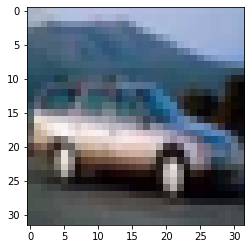

In [434]:
orig = trainset[4][0] #3x32x32
label = trainset[4][1]
img = denormalize(orig)
print(label)
plt.imshow(img.numpy().transpose(1,2,0))

In [768]:
import torch.nn as nn
import torch.nn.functional as F


class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [769]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class RFNNet(nn.Module):
    def __init__(self, mu=.1, sigma=.05):
        super(RFNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.mu = mu
        self.sigma = sigma
        self.shape_vals = None

    def forward(self, x):
        x = self.random_masks(x) * x
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def random_masks(self, batch):
        # Set various shape values once to speed processing
        if self.shape_vals is None:
            self.shape_vals = batch.size(), batch[0].size(), batch[0].nelement()
            print(self.shape_vals)
            
        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])
        
        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

In [770]:
# load basic model
PATH = './models/basic_cifar_net.pth'

basicnet = BasicNet()
basicnet.load_state_dict(torch.load(PATH))
basicnet.to(device)
basicnet.eval()

# load random feature nullification (RFN) model
PATH = './models/rfn_cifar_net.pth'

rfnnet = RFNNet(mu=.1, sigma=0) #sigma set to 0 in testing reproduceablity
rfnnet.load_state_dict(torch.load(PATH))
rfnnet.to(device)
rfnnet.eval()

#same criterion for both
criterion = nn.CrossEntropyLoss()

In [810]:
def fgsm_batch(net, orig, eps=10):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    '''
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig'''
    
    return inp

In [601]:
def fgsm_sample(net, orig, eps=10):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.unsqueeze(0).float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig
    
    return inp, perturbation, prior_pred, post_pred

In [604]:
def denormalize(tensor):
    denorm_tensor = tensor.clone().detach()
    for t, mean, std in zip(denorm_tensor, train_mean, train_std):
        t.mul_(std).add_(mean)
    return denorm_tensor.int().clamp(min=0, max=255)

def visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(f'FGSM sample with epsilon = {eps}', y=.8)
    ax[0].set_title(f'True: {label}, Pred {prior_pred}')
    ax[0].imshow(denormalize(orig).numpy().transpose(1,2,0))
    ax[1].set_title(f'Perturbation')
    ax[1].imshow(denormalize(perturbation).numpy().transpose(1,2,0))
    ax[2].set_title(f'Adv Pred: {post_pred}')
    ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))

In [ ]:
# load model
PATH = './models/basic_cifar_net.pth'

net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()
criterion = nn.CrossEntropyLoss()

tensor([[ 0.7040, -2.2849,  2.2663,  0.7440,  1.0590, -0.6345,  1.2335, -1.9254,
          1.6123, -1.6065]])
[0.3697967]
[2]


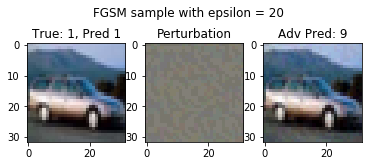

In [615]:
orig = trainset[4][0] #3x32x32
label = trainset[4][1]
eps = 20
inp, perturbation, prior_pred, post_pred = fgsm_sample(net, orig, eps=eps)
visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)
perturb_pred = net(perturbation.unsqueeze(0).to(device)).detach().cpu()
print(perturb_pred)
print(nn.functional.softmax(perturb_pred, dim=1).max(dim=1)[0].numpy())
print(nn.functional.softmax(perturb_pred, dim=1).max(dim=1)[1].numpy())

In [781]:
sample_idx = 10000

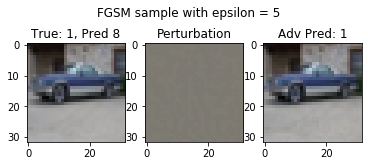

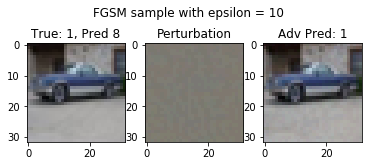

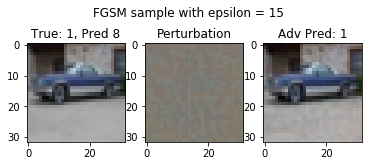

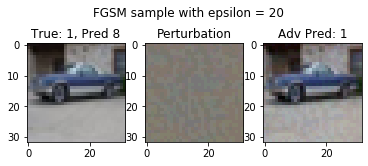

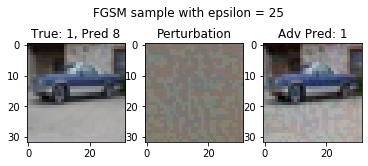

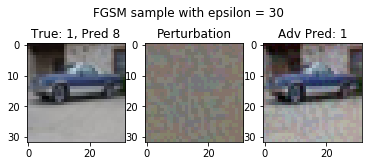

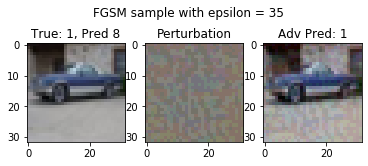

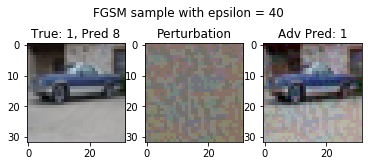

In [782]:
# FGSM vs Basic Net
num_samples = 1
trainlen = len(trainset)
eps_list = [5,10,15,20,25,30,35,40]

for i in range(num_samples):
    #sample_idx = int(random.random()*trainlen)
    for eps in eps_list:
        orig = trainset[sample_idx][0] #3x32x32
        label = trainset[sample_idx][1]
        inp, perturbation, prior_pred, post_pred = fgsm_sample(basicnet, orig, eps=eps)
        visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)


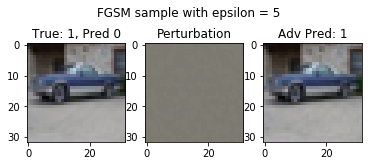

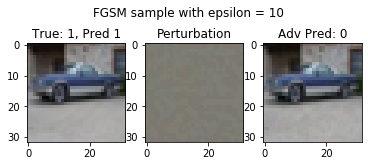

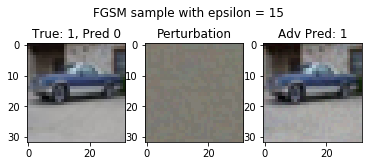

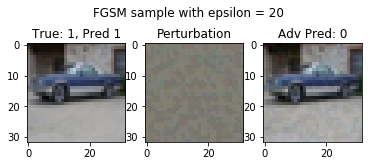

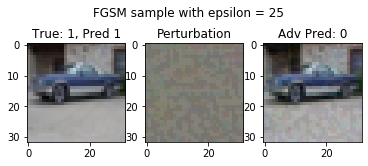

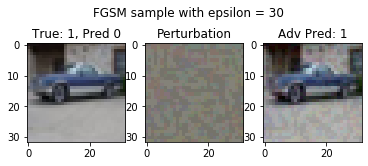

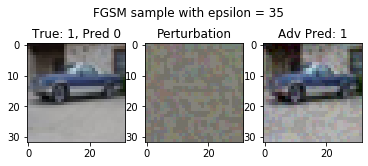

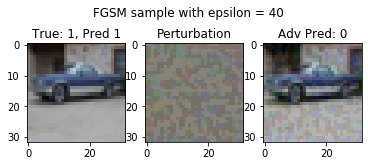

In [783]:
# FGSM vs RFN Net
num_samples = 1
trainlen = len(trainset)
eps_list = [5,10,15,20,25,30,35,40]

for i in range(num_samples):
    #sample_idx = int(random.random()*trainlen)
    
    for eps in eps_list:
        orig = trainset[sample_idx][0] #3x32x32
        label = trainset[sample_idx][1]
        inp, perturbation, prior_pred, post_pred = fgsm_sample(rfnnet, orig, eps=eps)
        visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)

In [786]:
train_dl = DataLoader(trainset, batch_size=1)


In [ ]:
def evalulate(net, dataloader, adv=False):
    correct = 0
    count = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if adv:
            inputs = fgsm_batch(net, inputs, eps = 10)
        preds = net(inputs)
        if torch.argmax(preds) == labels:
            correct += 1.0
        count += 1.0
        if not i % 5000:
            print(f'Sample: {i}, Running Accuracy: {(correct/count):5.3f}')
    acc = correct/count
    print(f'Accuracy over {int(count)} samples: {acc:5.3f}')
    return acc
        

In [805]:
eval(basicnet, train_dl, adv=False)

Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.509
Sample: 10000, Running Accuracy: 0.505
Sample: 15000, Running Accuracy: 0.505
Sample: 20000, Running Accuracy: 0.501
Sample: 25000, Running Accuracy: 0.503
Sample: 30000, Running Accuracy: 0.506
Sample: 35000, Running Accuracy: 0.504
Sample: 40000, Running Accuracy: 0.504
Sample: 45000, Running Accuracy: 0.504
Accuracy over 50000 samples: 0.505


In [812]:
eval(basicnet, train_dl, adv=True)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.366
Sample: 10000, Running Accuracy: 0.371
Sample: 15000, Running Accuracy: 0.371
Sample: 20000, Running Accuracy: 0.373
Sample: 25000, Running Accuracy: 0.374
Sample: 30000, Running Accuracy: 0.376
Sample: 35000, Running Accuracy: 0.374
Sample: 40000, Running Accuracy: 0.374
Sample: 45000, Running Accuracy: 0.375
Accuracy over 50000 samples: 0.375


In [813]:
eval(rfnnet, train_dl, adv=False)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.558
Sample: 10000, Running Accuracy: 0.558
Sample: 15000, Running Accuracy: 0.553
Sample: 20000, Running Accuracy: 0.552
Sample: 25000, Running Accuracy: 0.553
Sample: 30000, Running Accuracy: 0.554
Sample: 35000, Running Accuracy: 0.551
Sample: 40000, Running Accuracy: 0.550
Sample: 45000, Running Accuracy: 0.551
Accuracy over 50000 samples: 0.552


In [814]:
eval(rfnnet, train_dl, adv=True)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.465
Sample: 10000, Running Accuracy: 0.475
Sample: 15000, Running Accuracy: 0.476
Sample: 20000, Running Accuracy: 0.475
Sample: 25000, Running Accuracy: 0.478
Sample: 30000, Running Accuracy: 0.477
Sample: 35000, Running Accuracy: 0.476
Sample: 40000, Running Accuracy: 0.474
Sample: 45000, Running Accuracy: 0.474
Accuracy over 50000 samples: 0.474


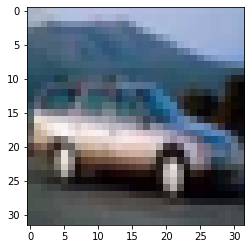

In [621]:
plt.imshow(denormalize(orig).numpy().transpose(1,2,0))

In [739]:
def random_mask(x, mu_p=.1, sig_p=.05):
    mask_prob = torch.tensor(sig_p * np.random.randn() + mu_p, device=device)
    print(mask_prob)
    zeros = torch.ceil(x.nelement()*mask_prob).int()
    print(zeros)
    mask = torch.ones(x.nelement())
    print(mask)
    mask[:zeros] = 0
    np.random.shuffle(mask.data)
    return mask.reshape(x.size()).float()

In [396]:
# prediction before attack
inp = Variable(orig.to(device).float().unsqueeze(0), requires_grad=True)

out = net(inp)
pred = np.argmax(out.data.cpu().numpy())
print(f'Prediction before attack: {pred} vs True: {label}')
loss = criterion(out, Variable(torch.Tensor([float(pred)]).to(device).long()))

# compute gradients
loss.backward()
#Create empty tensor of same shape as input image


eps = 1

# this is it, this is the method
inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
inp.data = inp.data.clamp(min=-1, max=1)
#inp.grad.data.zero_() # unnecessary

Prediction before attack: 1 vs True: 1


In [397]:
# predict on the adversarial image
pred_adv = np.argmax(net(inp).data.cpu().numpy())
print(f'After attack: eps {eps} True Label: {label} Post Label: {pred_adv}')

After attack: eps 1 True Label: 1 Post Label: 1


In [398]:
perturbation = torch.empty_like(orig)
adv = inp.data.cpu()[0]
perturbation = adv - orig

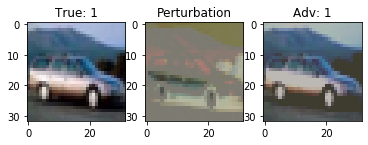

In [399]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].set_title(f'True: {label}')
ax[0].imshow(denormalize(orig).numpy().transpose(1,2,0))
ax[1].set_title(f'Perturbation')
ax[1].imshow(denormalize(perturbation).numpy().transpose(1,2,0))
ax[2].set_title(f'Adv: {pred_adv}')
ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))

In [298]:
# deprocess image
adv = inp.data.cpu().numpy()[0][0]
perturbation = adv-orig.numpy()
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)
perturbation = perturbation*255
perturbation = np.clip(perturbation, 0, 255).astype(np.uint8)

TypeError: Invalid shape (3, 32, 32) for image data

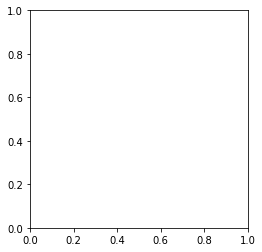

In [299]:
plt.imshow(adv)

In [42]:
!nvidia-smi

Wed Nov  6 15:19:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   53C    P2    39W / 180W |   1064MiB /  8117MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  